In [1]:
!pip install tensorflow-privacy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.1 MB/s eta 0:00:00


In [2]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold


#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Process Data

In [4]:
data  = pd.read_csv('/content/drive/MyDrive/RT_IOT2022.csv', index_col = 0)

In [5]:
# Multiclass problem
target_column = 'Attack_type'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb', 'ARP_poisioning',
       'DDOS_Slowloris', 'DOS_SYN_Hping', 'Metasploit_Brute_Force_SSH',
       'NMAP_FIN_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
       'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN'], dtype=object)

In [6]:
# Lets keet top 3 groups and implement imbalancing
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DOS_SYN_Hping','Thing_Speak','ARP_poisioning'])]

In [7]:
# Add Upsampling
from imblearn.over_sampling import RandomOverSampler
# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform upsampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [8]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data['Attack_type'] = label_encoder.fit_transform(data['Attack_type'])

In [9]:
# Identify non-numeric columns (only two so dropping)
print(data.select_dtypes(include='object').columns)

data.drop(['proto', 'service'], axis=1, inplace=True)

Index(['proto', 'service'], dtype='object')


In [10]:
target_column = 'Attack_type'
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

# Reshape data for LSTM

#I now convert the scaled training set into a NP Arrays and then reshape it

#I reshaped it to be compatible with the expected inputs by LSTM model
X_train_numpy = X_train_scaled[categorical_columns].to_numpy()
X_train_lstm = X_train_numpy.reshape(X_train_numpy.shape[0], 1, X_train_numpy.shape[1])

X_valid_array = X_valid_scaled[categorical_columns].to_numpy()

X_valid_reshaped = X_valid_array.reshape(X_valid_array.shape[0], 1, X_valid_array.shape[1])

## Hypertune

In [11]:
!pip install keras-tuner --upgrade --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.0 MB/s eta 0:00:00


In [12]:
import keras_tuner as kt

In [13]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np

In [14]:
# Build hypertunable model (adjust number of nodes, number of layers, learning rate, optimizer and dropout)
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=8, max_value=64, step=8),
                   input_shape=((1, len(categorical_columns)))))

    for i in range(hp.Int('num_layers', 1, 3)):  # Tunable number of Dense layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=8, max_value=64, step=8)))

    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    model.add(Dense(num_classes, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# random search method for best hyperparameter

In [ ]:
tuner = kt.RandomSearch(build_lstm_model,
                      objective='val_loss',
                      max_trials=150)  # Change max trials to 100 for the full experiment

tuner.search(X_train_lstm, y_train, epochs=50, validation_data=(X_valid_reshaped , y_valid)) # Change Epochs as well
best_model = tuner.get_best_models()[0]

In [16]:
# SAVE THIS best architectural configuration
best_model.summary()
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 2880      
                                                                 
 dense (Dense)               (None, 56)                504       
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                684       
                                                                 
Total params: 4068 (15.89 KB)
Trainable params: 4068 (15.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l

## LSTM Default

In [17]:
from keras.callbacks import EarlyStopping
# Early stopping (make patience bigger if stopping too early)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
# Create a simpler LSTM model with a smaller number of units and dropout
model = Sequential()
model.add(LSTM(16, input_shape=(1, len(categorical_columns))))

#Used dropout function to avoid overfitting by dropping 50% of the neurons in the previous layer.
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Increase the learning rate for SGD optimizer
#When  the learning rate is higher the accuracy increase/decrease
learning_rate = 0.003
sgd_optimizer = SGD(learning_rate=learning_rate)
model.compile(optimizer=sgd_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on this fold
    model_history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=128, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))


# Predict on the test data
X_test_array = X_test_scaled[categorical_columns].to_numpy()
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

y_test_pred = model.predict(X_test_reshaped)

Epoch 1/50
1243/1243 [==============================] - 15s 10ms/step - loss: 1.8976 - accuracy: 0.6179 - val_loss: 1.4155 - val_accuracy: 0.7593
Epoch 2/50
1243/1243 [==============================] - 7s 5ms/step - loss: 1.1572 - accuracy: 0.7620 - val_loss: 0.9074 - val_accuracy: 0.7396
Epoch 3/50
1243/1243 [==============================] - 9s 7ms/step - loss: 0.8228 - accuracy: 0.7811 - val_loss: 0.6769 - val_accuracy: 0.7689
Epoch 4/50
1243/1243 [==============================] - 7s 6ms/step - loss: 0.6612 - accuracy: 0.8020 - val_loss: 0.5535 - val_accuracy: 0.8137
Epoch 5/50
1243/1243 [==============================] - 9s 7ms/step - loss: 0.5692 - accuracy: 0.8179 - val_loss: 0.4775 - val_accuracy: 0.9296
Epoch 6/50
1243/1243 [==============================] - 4s 4ms/step - loss: 0.5054 - accuracy: 0.8338 - val_loss: 0.4238 - val_accuracy: 0.9357
Epoch 7/50
1243/1243 [==============================] - 4s 3ms/step - loss: 0.4601 - accuracy: 0.8462 - val_loss: 0.3818 - val_accurac

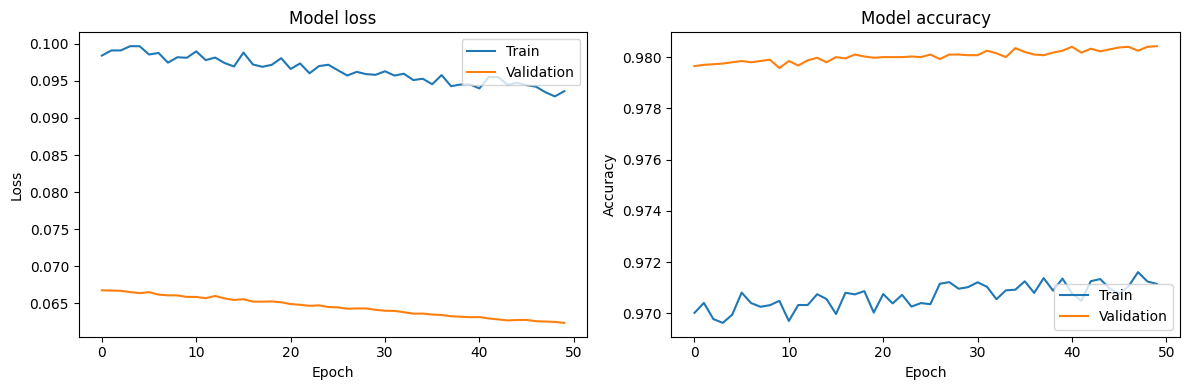

In [19]:
# Function to plot loss curves
def plot_loss(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

In [20]:
# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred, axis=1)

# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.07781030908226967
Average cross-validation accuracy: 0.9783331632614136
MLP Model:
Accuracy =  0.9800690189449961
Precision = 0.9802173617939074
Recall = 0.9801218578982747
F1 Score =  0.9800981085390396


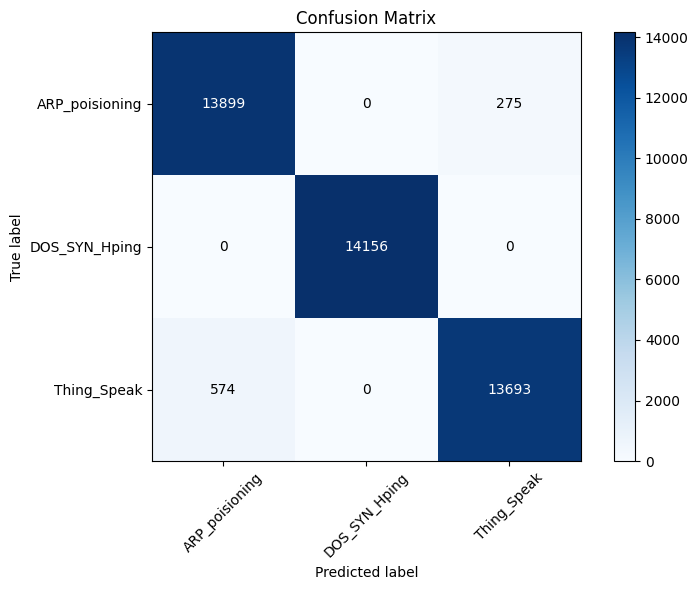

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

## Privacy

In [22]:
# Set hyperparameters for privacy-preserving training
batch_size = 64,128,256  # Number of samples in each training batch
l2_norm_clip = 1.5  # Upper bound on the L2 norm of model's gradients
noise_multiplier = 1.3  # Multiplier for the Gaussian noise added to gradients
num_microbatches = 128  # Number of microbatches for training
learning_rate = 0.001,0.0001  # Learning rate for the optimizer

# Ensure that batch size is a multiple of the number of microbatches
if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Initialize a differentially private stochastic gradient descent optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Define the loss function for the model
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [23]:
# Create a simpler LSTM model with a smaller number of units and dropout
model_privacy = Sequential()
model_privacy.add(LSTM(16, input_shape=(1, len(categorical_columns))))

#Used dropout function to avoid overfitting by dropping 50% of the neurons in the previous layer.
model_privacy.add(Dropout(0.5))
model_privacy.add(Dense(num_classes, activation='softmax'))

In [24]:
# Compile the model outside the loop if the architecture and optimizer are consistent
model_privacy.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Reshape labels to be logtis (see shape check below)
    y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=num_classes)

    # Need to reshape data to batch divisilbe size
    new_size = (X_train_fold.shape[0] // batch_size) * batch_size
    X_train_lstm_trimmed = X_train_fold[:new_size]
    y_train2 = y_train_fold2[:new_size]

    new_size = (X_val_fold.shape[0] // batch_size) * batch_size
    X_valid_reshaped_trimmed = X_val_fold[:new_size]
    y_valid2 = y_val_fold2[:new_size]

    # Train the model on this fold
    model_history_privacy = model_privacy.fit(
        X_train_lstm_trimmed , y_train2, epochs=50, batch_size=batch_size,validation_data=(X_valid_reshaped_trimmed , y_valid2),
        callbacks=[early_stopping])

    # Evaluate on the validation set
    val_loss, val_accuracy = model_privacy.evaluate(X_valid_reshaped_trimmed , y_valid2)
    cv_results.append((val_loss, val_accuracy))


Epoch 1/50
1242/1242 [==============================] - 45s 27ms/step - loss: 0.9730 - accuracy: 0.5789 - val_loss: 0.8099 - val_accuracy: 0.7279
Epoch 2/50
1242/1242 [==============================] - 34s 28ms/step - loss: 0.7534 - accuracy: 0.7323 - val_loss: 0.6426 - val_accuracy: 0.7393
Epoch 3/50
1242/1242 [==============================] - 33s 26ms/step - loss: 0.6348 - accuracy: 0.7603 - val_loss: 0.5410 - val_accuracy: 0.7605
Epoch 4/50
1242/1242 [==============================] - 33s 27ms/step - loss: 0.5589 - accuracy: 0.7829 - val_loss: 0.4749 - val_accuracy: 0.8918
Epoch 5/50
1242/1242 [==============================] - 33s 27ms/step - loss: 0.5077 - accuracy: 0.8026 - val_loss: 0.4278 - val_accuracy: 0.8846
Epoch 6/50
1242/1242 [==============================] - 32s 26ms/step - loss: 0.4674 - accuracy: 0.8191 - val_loss: 0.3915 - val_accuracy: 0.8826
Epoch 7/50
1242/1242 [==============================] - 34s 27ms/step - loss: 0.4381 - accuracy: 0.8325 - val_loss: 0.3617 -

In [25]:
# Predict on the test data
y_test_pred_mlp_privacy = model_privacy.predict(X_test_reshaped)

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

1332/1332 [==============================] - 2s 1ms/step


In [26]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 0.1769993394613266
Average cross-validation accuracy: 0.9496572732925415
MLP Model:
Accuracy =  0.9676268281803883
Precision = 0.9682361995043031
Recall = 0.9677256327184596
F1 Score =  0.9676509208098641


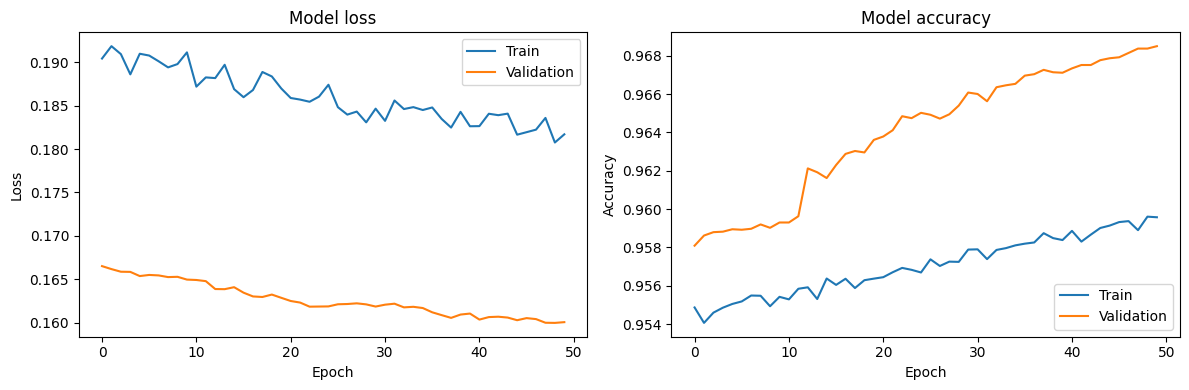

In [27]:
# Plot loss curves
plot_loss(model_history_privacy)

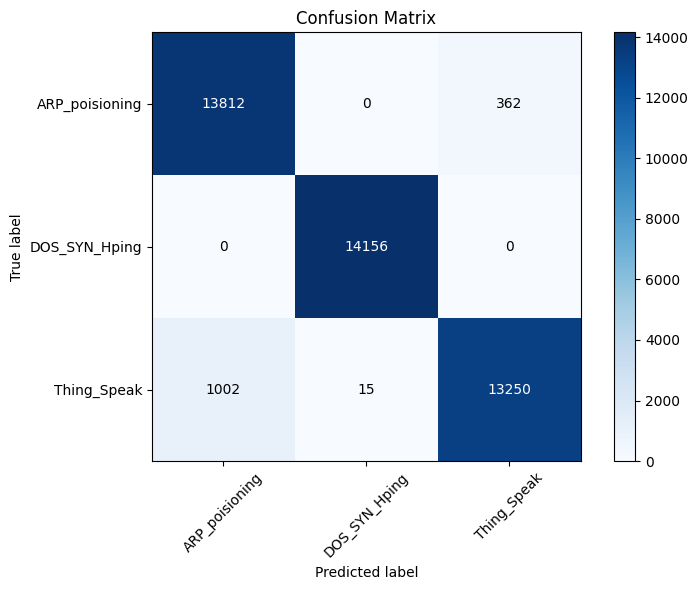

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [29]:
# help(compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy)

In [30]:
# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_lstm_trimmed),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=50,
    delta=1e-5
)

In [31]:
print(privacy_report)

DP-SGD performed over 158976 examples with 128 examples per iteration, noise
multiplier 1.3 for 50 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:       109.529
    Epsilon assuming Poisson sampling (*):                      3.469

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.

